In [34]:
import sys
import os
import pandas as pd
from datetime import datetime
from helper_functions import fetch_granular_data,fetch_and_save_csv_files, csv_to_df
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np
%matplotlib inline

donor_data = fetch_granular_data()
donor_data['visit_date'] = donor_data['visit_date'] = pd.to_datetime(donor_data['visit_date'])
donor_data.sort_values(['donor_id','visit_date'], inplace=True)

In [35]:
donor_data['Cohort'] = donor_data.groupby('donor_id')['visit_date'].transform('min').dt.strftime('%Y-%m')
donor_data['Order'] = donor_data.groupby('donor_id').cumcount() + 1


In [36]:
cohort_data = donor_data.groupby(['Cohort', 'Order']).agg(n_donors=('donor_id', 'nunique')).reset_index()
cohort_pivot = cohort_data.pivot_table(index='Cohort', columns='Order', values='n_donors')

cohorts = pd.period_range(cohort_pivot.index.min(), cohort_pivot.index.max(), freq='M').strftime('%Y-%m')
cohort_pivot = cohort_pivot.reindex(cohorts)


In [39]:
cohort_sizes = cohort_pivot.iloc[:,0]
retention = cohort_pivot.divide(cohort_sizes,axis = 0)

retention


Order,1,2,3,4,5,6,7,8,9,10,...,302,303,304,305,306,307,308,309,310,311
2012-01,1.0,0.678550,0.518001,0.417931,0.347061,0.296108,0.256949,0.227722,0.204215,0.183408,...,0.000054,0.000054,0.000054,0.000027,0.000027,0.000027,0.000027,0.000027,0.000027,0.000027
2012-02,1.0,0.697587,0.532428,0.430508,0.359187,0.302669,0.260783,0.227150,0.199189,0.175680,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-03,1.0,0.708685,0.550255,0.445352,0.371034,0.317589,0.273295,0.240556,0.212911,0.190609,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-04,1.0,0.702854,0.545389,0.437882,0.360931,0.300940,0.254215,0.217786,0.187362,0.164098,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-05,1.0,0.695705,0.532384,0.422130,0.344145,0.285639,0.238571,0.200204,0.171100,0.146313,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09,1.0,0.064763,0.000199,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-10,1.0,0.022933,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-11,1.0,0.002426,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-12,1.0,0.000115,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


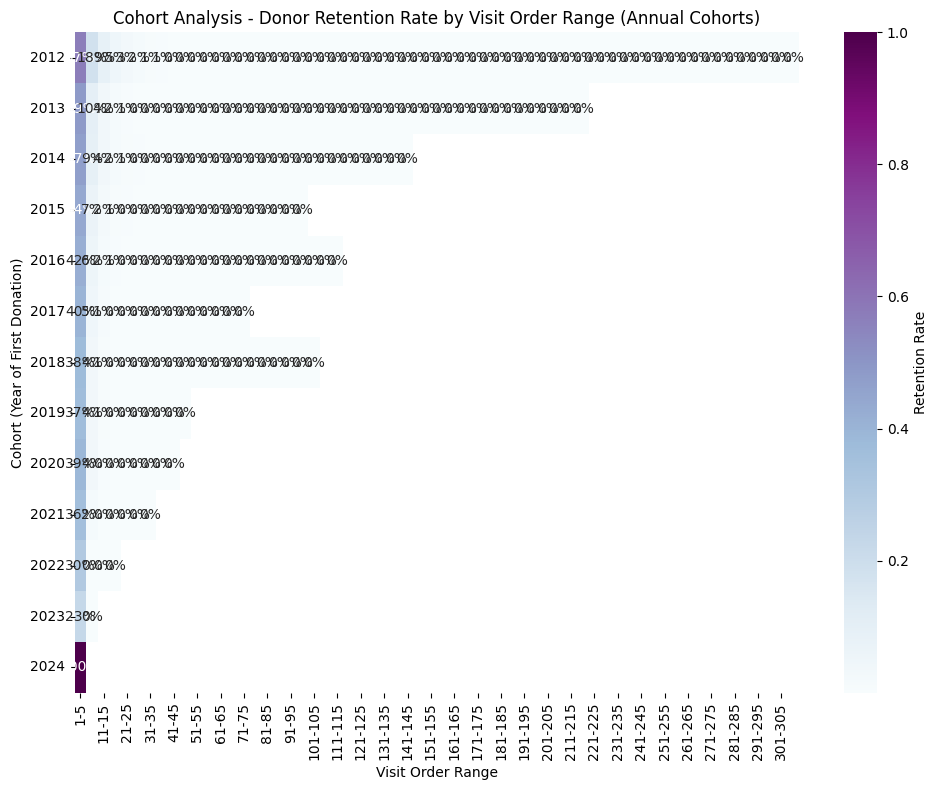

In [47]:
# Assuming the 'retention' DataFrame exists and is formatted correctly
# with cohorts as the index and visit orders as the columns

# Change the cohort index to year only
retention.index = pd.to_datetime(retention.index).year

# Aggregate retention data by year
retention_by_year = retention.groupby(retention.index).mean()

# Define bins for the order of visits
max_order = retention_by_year.columns.max()
bins = range(0, max_order + 1, 5)  # Bins of 5 visits, adjust as needed
labels = [f'{i + 1}-{i + 5}' for i in bins[:-1]]

# Initialize an empty DataFrame to hold the binned data
retention_binned_by_year = pd.DataFrame(index=retention_by_year.index.unique(), columns=labels)

# Calculate the mean retention rate for each bin range
for i, label in enumerate(labels):
    start_col = i * 5
    end_col = start_col + 5
    retention_binned_by_year[label] = retention_by_year.iloc[:, start_col:end_col].mean(axis=1)

# Plot the heatmap with the binned data
plt.figure(figsize=(10, 8))  # Adjust the figure size as needed
sns.heatmap(retention_binned_by_year, annot=True, fmt='.0%', cmap='BuPu', cbar_kws={'label': 'Retention Rate'})

# Rotate the x and y axis labels for better readability
plt.xticks(rotation=90)
plt.yticks(rotation=0)

# Set the title and axis labels
plt.title('Cohort Analysis - Donor Retention Rate by Visit Order Range (Annual Cohorts)')
plt.xlabel('Visit Order Range')
plt.ylabel('Cohort (Year of First Donation)')
plt.tight_layout()  # Ensure everything fits without overlap
plt.show()
